## RegressionProject

In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

In [50]:
df = pd.read_csv('Fish.csv')

Information about dataset.

In [51]:
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [52]:
df.shape

(159, 7)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


In [54]:
df.isna().sum()

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64

In this dataset, each cell has a value, so I don't need to deal with processing of missing values. All features have `float64` type, with the exception of the `Species` feature, it's values are of type `object`. In the future I processing this feature with `pd.get_dummies(X)` fanction and will work with it as with categorical data.

We will predict the weight of fishs, it means as `TARGET` we will use `Weight` feature.

In [56]:
TARGET = 'Weight'
X_df = df.drop([TARGET], axis=1)
y_df = df[TARGET]

Let's split the data into `test` and` train`.

In [57]:
RANDOM_STATE = 21
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=RANDOM_STATE)

In [58]:
X_train.head()

,Species,Length1,Length2,Length3,Height,Width
45,Roach,20.5,22.5,25.3,7.0334,3.8203
111,Perch,32.5,35.0,37.3,11.4884,7.7957
146,Smelt,10.0,10.5,11.6,1.9720,1.1600
158,Smelt,13.8,15.0,16.2,2.9322,1.8792
54,Roach,29.5,31.7,35.0,9.4850,5.3550


In [59]:
y_train.head()

45     160.0
111    840.0
146      7.5
158     19.9
54     390.0
Name: Weight, dtype: float64

We will display the main information about the data for better understanding of the situation.

In [60]:
X_train.describe()

,Length1,Length2,Length3,Height,Width
count,111.000000,111.000000,111.000000,111.000000,111.000000
mean,26.188288,28.359459,31.092793,8.927363,4.459573
std,10.130626,10.866582,11.752707,4.335018,1.768310
min,7.500000,8.400000,8.800000,1.728400,1.148400
25%,19.000000,20.750000,22.500000,5.830250,3.316250
50%,25.000000,27.000000,29.300000,8.145400,4.234000
75%,33.600000,36.450000,40.150000,11.844900,6.098600
max,59.000000,63.400000,68.000000,18.957000,7.795700


<AxesSubplot:>

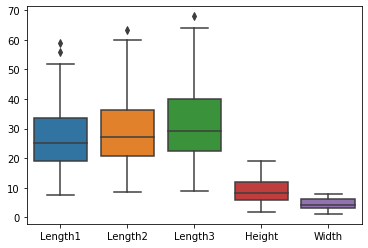

In [61]:
sns.boxplot(data = X_train)

<AxesSubplot:xlabel='Weight'>

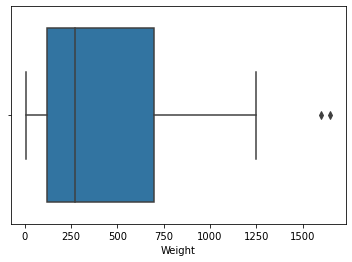

In [65]:
sns.boxplot(y_train)

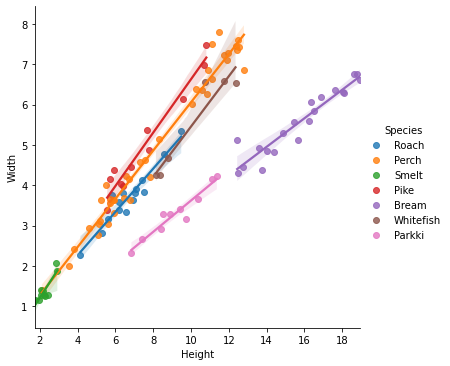

In [74]:
sns.lmplot(x='Height',y='Width', hue='Species', data=X_train)

<AxesSubplot:xlabel='Height', ylabel='Width'>

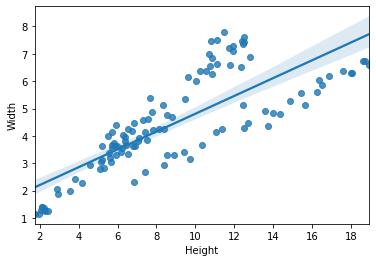

In [85]:
sns.regplot(x=X_train['Height'],y=X_train['Width'])

<AxesSubplot:xlabel='Height', ylabel='Width'>

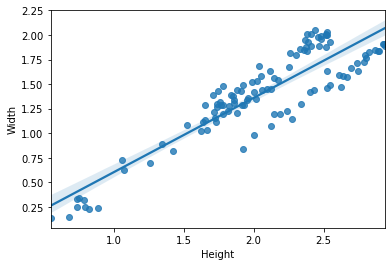

In [84]:
sns.regplot(x=np.log(X_train['Height']),y=np.log(X_train['Width']))

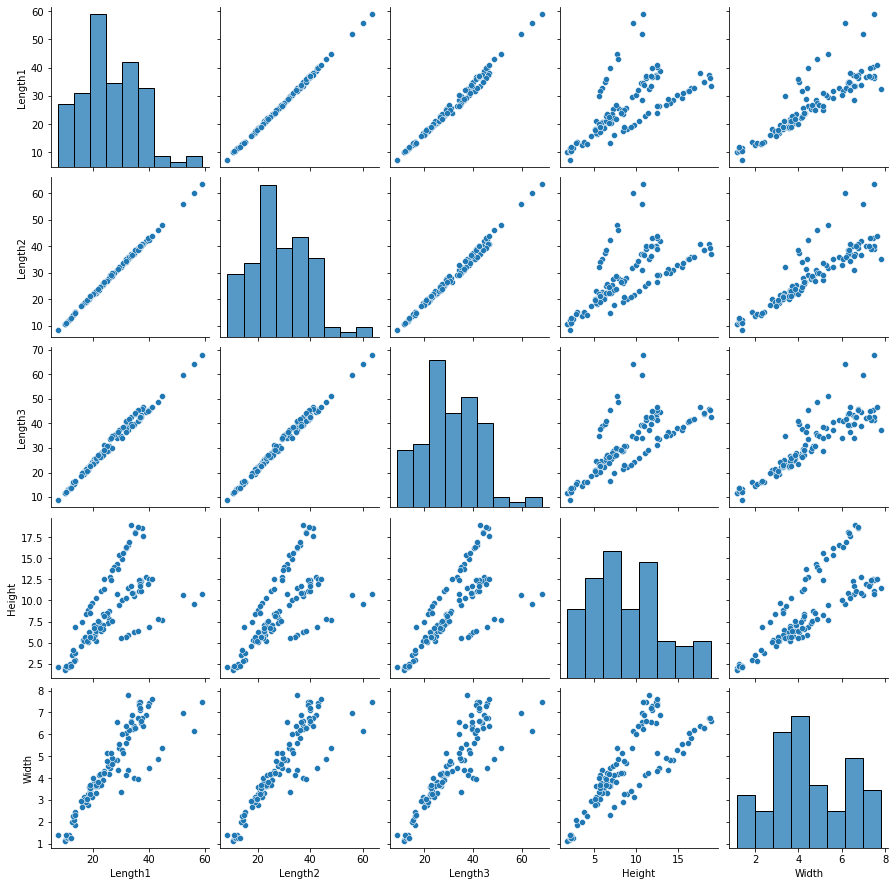

In [71]:
sns.pairplot(X_train)

In [98]:
train = X_train.join(y_train.to_frame())

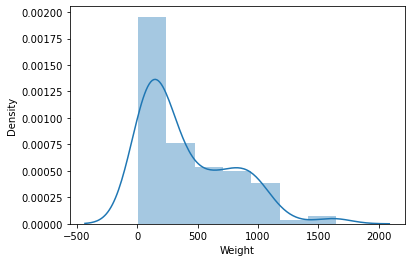

In [137]:
ax = sns.distplot(train[TARGET], norm_hist=True)

Based on the graphs, the following preliminary estimates / conclusions can be made:

1) Features `Length1`, `Length2`, `Length3` are quite strongly correlated, you can see this by looking at proportionally similar values when consideri the `describe()` method, visually this is clearly visible on box plot and at intersections in pairplot. You can finally be convinced of this by looking at the heatmap. In linear models, we will carry out the regularization in order to negate the effect of multicollinearity.

2) According to the mlplot graph, you can see that each of the values of the `Species` feature is quite well separable from the others, especially `Parkki` and `Bream`, and `Perch` is the worst separable. So we can conclude that this feature will be useful for predictions.

3) Features `Height` and `Width` most likely correlate poorly with each other and other features, so they won't be afraid of the multicollinearity effect. Based on the heatmap, it can be understood that the assumption was correct.

<AxesSubplot:>

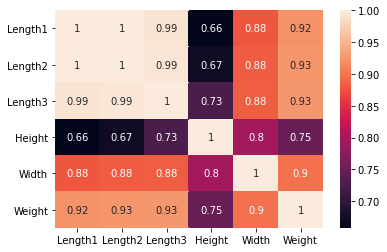

In [202]:
corr = train.corr()
condition = np.abs(corr[TARGET]) > 0.5
top_corr = corr.loc[condition,condition]
sns.heatmap(top_corr, annot=True)

As we can see, all the features strongly correlate with `TARGET`. Let's create another Dataframe, in which we will normalize the features for potentially better work with linear models.

In [278]:
def to_scaler(train_copy):
    scaler = StandardScaler()
    new_train = scaler.fit_transform(train_copy)
    X_scaler_train = pd.DataFrame(new_train, index=train_copy.index, columns=train_copy.columns)
    return X_scaler_train

<AxesSubplot:>

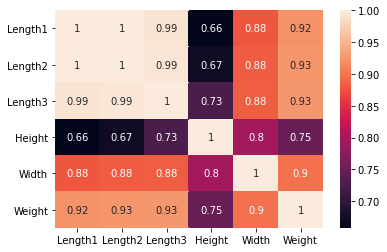

In [207]:
corr = (to_scaler(train).join(y_train.to_frame())).corr()
sns.heatmap(corr, annot=True)

In [208]:
scaler_train = to_scaler(train).join(y_train.to_frame())

Use `pd.get_dummies(X)`

In [253]:
X_df = pd.get_dummies(df).drop([TARGET], axis=1)
y_df = pd.get_dummies(df)[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=RANDOM_STATE)

Let's try different models for prediction `Weight` values.

### Linear regression

In [264]:
def evaluate_model(train, val, tr_y, val_y, pipeline):
    pipeline.fit(train, tr_y)
    pred_val = pipeline.predict(val)
    pred_train = pipeline.predict(train)

    print('Score for train:',pipeline.score(train,tr_y))
    print('Score for test:',pipeline.score(val,val_y))
    
    return pd.DataFrame({
        'train_RMSE': [np.sqrt(mean_squared_error(tr_y, pred_train))], 
        'train_R2': [r2_score(tr_y, pred_train)],
        'val_RMSE': [np.sqrt(mean_squared_error(val_y, pred_val))],
        'val_R2': [r2_score(val_y, pred_val)]
    })

In [265]:
linreg = LinearRegression()
scores = evaluate_model(X_train, X_test, y_train, y_test, linreg)
scores

Score for train: 0.9404586441231115
Score for test: 0.9142814015440207


,train_RMSE,train_R2,val_RMSE,val_R2
0,91.237883,0.940459,91.470078,0.914281


In [274]:
scores = evaluate_model(to_scaler(X_train), to_scaler(X_test), y_train, y_test, linreg)
scores

Score for train: 0.9404586441231115
Score for test: 0.8991942372033124


,train_RMSE,train_R2,val_RMSE,val_R2
0,91.237883,0.940459,99.193725,0.899194


In [279]:
linreg = LinearRegression(normalize=True)
scores = evaluate_model(X_train, X_test, y_train, y_test, linreg)
scores

Score for train: 0.9404586441231115
Score for test: 0.914281401544021


,train_RMSE,train_R2,val_RMSE,val_R2
0,91.237883,0.940459,91.470078,0.914281


In [361]:
linreg = GridSearchCV(Lasso(normalize=True), {'alpha':[0.19,0.85,0.195,1.3]})
scores = evaluate_model(X_train, X_test, y_train, y_test, linreg)
print(linreg.best_params_)
scores

Score for train: 0.9381030199892442
Score for test: 0.9052010435967695
{'alpha': 0.19}


,train_RMSE,train_R2,val_RMSE,val_R2
0,93.025191,0.938103,96.192962,0.905201


In [366]:
linreg = GridSearchCV(Ridge(), {'alpha':[0.825,0.85, 0.875]})
scores = evaluate_model(X_train, X_test, y_train, y_test, linreg)
print(linreg.best_params_)
scores

Score for train: 0.9383077675757354
Score for test: 0.9061297610444403
{'alpha': 0.825}


,train_RMSE,train_R2,val_RMSE,val_R2
0,92.871206,0.938308,95.720615,0.90613


In [303]:
linreg = GridSearchCV(ElasticNet(), {'alpha':[1.1,1.2,1.3,1.4,1.5],'l1_ratio':[0.8,0.9,1]}, n_jobs=1)
scores = evaluate_model(X_train, X_test, y_train, y_test, linreg)
print(linreg.best_params_)
scores

Score for train: 0.9373288295024501
Score for test: 0.9016344021092494
{'alpha': 1.3, 'l1_ratio': 1}


,train_RMSE,train_R2,val_RMSE,val_R2
0,93.60515,0.937329,97.985799,0.901634


In [372]:
linreg = GridSearchCV(ElasticNet(normalize=True), {'alpha':[0.175,0.2,0.225,0.4,0.5],'l1_ratio':[0.8,0.9,1]}, n_jobs=1)
scores = evaluate_model(X_train, X_test, y_train, y_test, linreg)
print(linreg.best_params_)
scores

Score for train: 0.9382093866947795
Score for test: 0.9054108043574758
{'alpha': 0.175, 'l1_ratio': 1}


,train_RMSE,train_R2,val_RMSE,val_R2
0,92.945227,0.938209,96.08648,0.905411


As we can see, standard linear regression is pretty good at predicting.

### KNN

In [424]:
neighbor = KNeighborsRegressor()
neighbor = GridSearchCV(neighbor, {'n_neighbors':[1,2,3,4,5,6], 'weights':['uniform', 'distance'], 'algorithm':['auto','ball_tree','kd_tree','brute']}, n_jobs=1, cv=5)
scores = evaluate_model(X_train, X_test, y_train, y_test, neighbor)
print(neighbor.best_params_)
scores

Score for train: 1.0
Score for test: 0.9669046241798894
{'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}


,train_RMSE,train_R2,val_RMSE,val_R2
0,0.0,1.0,56.836219,0.966905


KNN gives very good predictions, it made sense to check it, since we have a small number of features, and those that exist correlate well with `TARGET`.

### Random forest

In [375]:
rfr = RandomForestRegressor()
rfr = GridSearchCV(rfr, {'n_estimators':[50,75,100],'max_depth':[15,20,25],'min_samples_split':[2,3,4,5]}, n_jobs=1, cv=5)
scores = evaluate_model(X_train, X_test, y_train, y_test, rfr)
print(rfr.best_params_)
scores

Score for train: 0.9953068713466003
Score for test: 0.9754102454038228
{'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 50}


,train_RMSE,train_R2,val_RMSE,val_R2
0,25.61516,0.995307,48.991261,0.97541


As expected, Random forest performed with a very good result (approximately 97.5% of correct answers), a decent level of prediction of the model is also confirmed by the estimates of `RMSE` and `R2`.

### Boosting

There are several boosting models that can work well with our data. Let's try a few of them.

#### LightGBM

In [412]:
lgbm = LGBMRegressor(random_state=RANDOM_STATE)
lgbm = GridSearchCV(lgbm, {'n_estimators':[30,20,10,40],'learning_rate':[0.15,0.1,0.2]}, n_jobs=1, cv=5)
scores = evaluate_model(X_train, X_test, y_train, y_test, lgbm)
print(lgbm.best_params_)
scores

Score for train: 0.9339988011319322
Score for test: 0.8719058768266313
{'learning_rate': 0.15, 'n_estimators': 30}


,train_RMSE,train_R2,val_RMSE,val_R2
0,96.059817,0.933999,111.816559,0.871906


#### AdaptBoosting

In [414]:
adaboost = AdaBoostRegressor(random_state=RANDOM_STATE)
adaboost = GridSearchCV(adaboost, {'n_estimators':[35,50,65,100],'learning_rate':[0.75,0.5,0.25]}, n_jobs=1, cv=5)
scores = evaluate_model(X_train, X_test, y_train, y_test, adaboost)
print(adaboost.best_params_)
scores

Score for train: 0.9898410464147049
Score for test: 0.9719546098475217
{'learning_rate': 0.5, 'n_estimators': 50}


,train_RMSE,train_R2,val_RMSE,val_R2
0,37.686893,0.989841,52.320545,0.971955


#### XGBoost

In [410]:
reg = xgb.XGBRegressor(random_state=RANDOM_STATE)
reg = GridSearchCV(reg, {'max_depth':[10,15,20],'n_estimators':[70,75,80,],
                         'learning_rate':[0.20,0.15,0.1]}, n_jobs=1, cv=5)
scores = evaluate_model(X_train, X_test, y_train, y_test, reg)
print(reg.best_params_)
scores

Score for train: 0.9999999945418463
Score for test: 0.961797515252884
{'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 80}


,train_RMSE,train_R2,val_RMSE,val_R2
0,0.027624,1.0,61.064292,0.961798


#### CatBoost

In [422]:
ctr = CatBoostRegressor()
clf = GridSearchCV(ctr, {'max_depth':[10,15,20,25,30], 'n_estimators':[30,35,38,40,43], 
                        'learning_rate': [0.1,0.09,0.2]}, n_jobs = -1)
scores = evaluate_model(X_train, X_test, y_train, y_test, clf)
print(clf.best_params_)
scores

0:	learn: 322.2836169	total: 430ms	remaining: 16.8s
1:	learn: 287.3360130	total: 434ms	remaining: 8.25s
2:	learn: 252.9535517	total: 443ms	remaining: 5.46s
3:	learn: 223.5315369	total: 452ms	remaining: 4.06s
4:	learn: 201.1375854	total: 456ms	remaining: 3.19s
5:	learn: 180.2914999	total: 465ms	remaining: 2.63s
6:	learn: 159.5480763	total: 467ms	remaining: 2.2s
7:	learn: 143.4543897	total: 476ms	remaining: 1.9s
8:	learn: 128.2347695	total: 484ms	remaining: 1.67s
9:	learn: 115.5293392	total: 493ms	remaining: 1.48s
10:	learn: 103.7963463	total: 501ms	remaining: 1.32s
11:	learn: 94.4605168	total: 510ms	remaining: 1.19s
12:	learn: 86.5482843	total: 518ms	remaining: 1.08s
13:	learn: 79.3169264	total: 523ms	remaining: 971ms
14:	learn: 72.8155160	total: 531ms	remaining: 885ms
15:	learn: 67.4668730	total: 540ms	remaining: 809ms
16:	learn: 62.9049964	total: 540ms	remaining: 731ms
17:	learn: 58.6445691	total: 543ms	remaining: 664ms
18:	learn: 54.8952966	total: 546ms	remaining: 603ms
19:	learn: 51

,train_RMSE,train_R2,val_RMSE,val_R2
0,24.105529,0.995844,52.097,0.972194


After making predictions, the following conclusions can be done:

1) `Linear regression` worked worse than other methods, normalization of the model using StandardScaler helped a bit. Perhaps, if we can still fight with multicollenarity and non-ideal linearity of the model in various ways, we will be able to get better forecast results.

2) `KNN` showed itself much better than linear regression, this is due to the small number of features relative to the number of rows in the Dataframe.

3) `Random Forest` turned out to be the most effective method, taking into account the selected parameters. Its `RMSE` and `R2` scores also indicate the high accuracy of the model.

4) The best among the boosting models turned out to be `AdaptBoosting` and` CatBoost`, where further tuning of the parameters `CatBoost` will look even more advantageous, this method was created for better work with categorical data that is available in this case. Because of its speed, `LightGBM` is excellent for preliminary estimation of parameters and then we can use these parameters as a baseline in subsequent methods.